<h1>Выделение групп пользователей пользователей мобильного приложения "Ненужные вещи" на основе поведения.<h1>

**Цель проекта:**

Исследовать поведение пользователей мобильного приложения, чтобы выделить группы пользователей, которые различаются по метрикам. Провести исследовательский анализ данных. Сегментировать пользователей. И проверить статистические гипотезы.

**Ход выполнения проекта**

1. Исследовательский анализ данных.
- Оценка Retention Rate
- Оценка времени, проведенного пользователем в приложении
- Оценка частоты действий
- Оценка конверсии в целевое событие (contacts_show)

2. Сегментация пользователей на группы.
- Выделение групп пользователей
- Оценка Retention Rate для каждой группы
- Оценка времени, проведенного пользователем в приложении для каждой группы
- Оценка частоты действий для каждой группы
- Оценка конверсии в целевое событие (contacts_show) для каждой группы

3. Проверка статистических гипотез.
- Группы пользователей, установивших приложение из `yandex` и `google`, демонстрируют разную конверсию в просмотры контактов.
- Группы пользователей, воспользовавшиеся поиском и кликнувших на рекомендованное объявление, демонстрируют разную конверсию в просмотры контактов (собственная гипотеза).

**Описание данных**

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.   
В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

### Знакомство с данными.

In [2]:
# импортируем нужные библитеки
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
import math
import numpy as np
from scipy import stats as st

In [3]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')
mobile_sourсes.head()

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

In [4]:
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
mobile_dataset.head()

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

In [5]:
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [6]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


 Мы имеем 2 таблицы с 4293 и 74197 строками. Пропусков не обнаружено. Преступим к предобработке данных.

### Предобработка данных.

In [7]:
# переименуем столбцы
mobile_sourсes.columns = ['user_id', 'source']
mobile_dataset.columns = ['event_time', 'event_name', 'user_id']

In [8]:
mobile_sourсes.duplicated().sum()

0

In [9]:
mobile_dataset.duplicated().sum()

0

Явные дубликаты не обнаружены.

In [10]:
display(mobile_sourсes['user_id'].nunique())
mobile_dataset['user_id'].nunique()

4293

4293

Количество уникальных пользователей в датасетах совпадает, следовательно можно объединить датасеты без потерь.

In [11]:
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

В названия событий присутствуют неявные дубликаты:
- `contacts_show` и `show_contacts`. Приведем все значения к `contacts_show`;
- `search_1` - `search_7`. Приведем все значения к `search`.

In [12]:
def events_type(name):
    if name == 'show_contacts':
        return 'contacts_show'
    elif 'search' in name:
        return 'search'
    return name

In [13]:
mobile_dataset['event_name'] = mobile_dataset['event_name'].apply(events_type)
mobile_dataset['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

In [14]:
mobile_sourсes['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

В датасете 3 вида источника, из которого было установлено приложение.

Приведем столбец `event_time` к типу date_time.
Также добавим столбец с датой события для дальнейшего определения пользовательских сессий.

In [15]:
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time']).dt.round('1S') 
mobile_dataset['date'] = mobile_dataset['event_time'].dt.date
mobile_dataset.head()

event_time   event_name                               user_id  \
0 2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
1 2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
2 2019-10-07 00:00:02    tips_show  cf7eda61-9349-469f-ac27-e5b6f5ec475c   
3 2019-10-07 00:00:07    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
4 2019-10-07 00:00:56  advert_open  cf7eda61-9349-469f-ac27-e5b6f5ec475c   

         date  
0  2019-10-07  
1  2019-10-07  
2  2019-10-07  
3  2019-10-07  
4  2019-10-07

In [16]:
display(mobile_dataset['date'].min())
mobile_dataset['date'].max()

datetime.date(2019, 10, 7)

datetime.date(2019, 11, 3)

Мы располагаем данными от 7 октября до 3 ноября 2019 года, т.е. ровно за 4 недели.

Таким образом, мы:
- Привели названия столбцов к единому виду;
- Проверили данные на пропуски;
- Проверили данные на явные дубликаты;
- Обработали неявные дубликаты;
- Привели столбцы к необходимым типам;
- Добавили столбец с датой и определили временной интервал.   

Можно переходить к Исследовательскому анализу данных.

### Исследовательский анализ данных.

Объединим датафреймы для удобства.

In [17]:
data = mobile_dataset.merge(mobile_sourсes, on='user_id', how='left')
data.head()

event_time   event_name                               user_id  \
0 2019-10-07 00:00:00  advert_open  020292ab-89bc-4156-9acf-68bc2783f894   
1 2019-10-07 00:00:01    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
2 2019-10-07 00:00:02    tips_show  cf7eda61-9349-469f-ac27-e5b6f5ec475c   
3 2019-10-07 00:00:07    tips_show  020292ab-89bc-4156-9acf-68bc2783f894   
4 2019-10-07 00:00:56  advert_open  cf7eda61-9349-469f-ac27-e5b6f5ec475c   

         date  source  
0  2019-10-07   other  
1  2019-10-07   other  
2  2019-10-07  yandex  
3  2019-10-07   other  
4  2019-10-07  yandex

#### Удержание пользователей в приложении (Retantion Rate).

Сначала найдем дату первой активности для каждого пользователя.

In [18]:
data['active_date'] = data['event_time'].astype('datetime64[W]')

first_ts = data.groupby('user_id').agg(first_ts=('date', 'min')).reset_index()
first_ts['first_ts'] = first_ts['first_ts'].astype('datetime64[W]')

data = first_ts.merge(data, on = 'user_id')
data.head()

user_id   first_ts          event_time  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:39:46   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:40:31   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:41:06   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:43:21   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:45:31   

  event_name        date source active_date  
0  tips_show  2019-10-07  other  2019-10-03  
1  tips_show  2019-10-07  other  2019-10-03  
2  tips_show  2019-10-07  other  2019-10-03  
3  tips_show  2019-10-07  other  2019-10-03  
4  tips_show  2019-10-07  other  2019-10-03

Найдем лайфтайм.

In [19]:
data['lifetime'] = (data['active_date'] - data['first_ts']).dt.days
data.head()

user_id   first_ts          event_time  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:39:46   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:40:31   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:41:06   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:43:21   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:45:31   

  event_name        date source active_date  lifetime  
0  tips_show  2019-10-07  other  2019-10-03         0  
1  tips_show  2019-10-07  other  2019-10-03         0  
2  tips_show  2019-10-07  other  2019-10-03         0  
3  tips_show  2019-10-07  other  2019-10-03         0  
4  tips_show  2019-10-07  other  2019-10-03         0

Построим таблицу удержания.

In [20]:
cohorts = data.groupby(['first_ts','lifetime']).agg({'user_id':'nunique'}).reset_index()
cohorts

first_ts  lifetime  user_id
0  2019-10-03         0      547
1  2019-10-03         7      148
2  2019-10-03        14       92
3  2019-10-03        21       60
4  2019-10-03        28       39
5  2019-10-10         0     1120
6  2019-10-10         7      262
7  2019-10-10        14      173
8  2019-10-10        21       79
9  2019-10-17         0     1136
10 2019-10-17         7      273
11 2019-10-17        14      101
12 2019-10-24         0     1014
13 2019-10-24         7      176
14 2019-10-31         0      476

Определим размеры когорт.

In [21]:
cohort_size = cohorts[cohorts['lifetime'] == 0][['first_ts','user_id']].rename(columns={'user_id':'cohort_users'})
cohort_size

first_ts  cohort_users
0  2019-10-03           547
5  2019-10-10          1120
9  2019-10-17          1136
12 2019-10-24          1014
14 2019-10-31           476

Найдем `Retention rate` для когорт.

In [22]:
cohorts = cohorts.merge(cohort_size, on='first_ts')
cohorts['retention'] = cohorts['user_id'] / cohorts['cohort_users']
retention = cohorts.pivot_table(index='first_ts',columns='lifetime',values='retention',aggfunc='sum')
retention

lifetime     0         7         14        21        28
first_ts                                               
2019-10-03  1.0  0.270567  0.168190  0.109689  0.071298
2019-10-10  1.0  0.233929  0.154464  0.070536       NaN
2019-10-17  1.0  0.240317  0.088908       NaN       NaN
2019-10-24  1.0  0.173570       NaN       NaN       NaN
2019-10-31  1.0       NaN       NaN       NaN       NaN

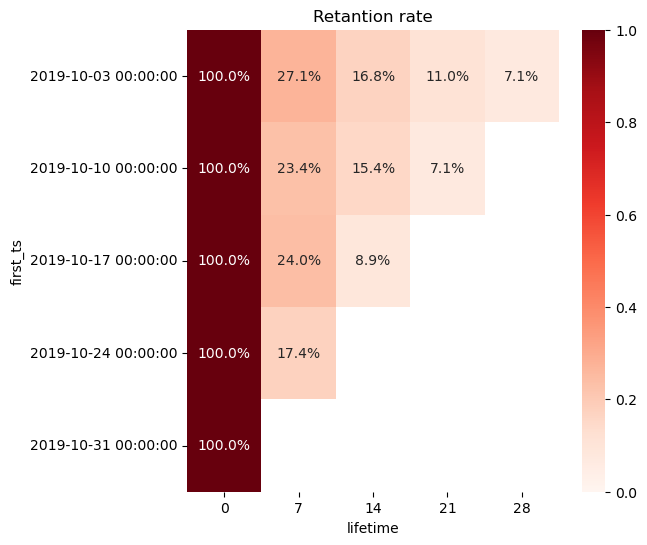

In [23]:
plt.figure(figsize=(6,6))
plt.title('Retantion rate')
ax = sns.heatmap(data=retention, annot=True, fmt='.1%', vmin=0.0,cmap='Reds')
ax.set_yticklabels(retention.index)
fig=ax.get_figure()
plt.show()

Данных для полной оценки удержания пользователей недостаточно. Но исходя из имеющихся данных, поведение пользователей схоже: после первой недели остается около четверти пользователей, а к концу наблюдения - меньше 10%. В целом удержание поользователей достаточно низкое, это должно настораживать. Необходим более подробный анализ на более полных данных.

#### Оценка времени, проведенного пользователем в приложении.

Сначала выделим сессии для пользователей. Примем длительность сессии за 30 минут, как это принято в системах аналитики. В нашем случае этого будет достаточно, но в дальнейшем необходимо выделять сессии во время сбора данных.

In [24]:
data = data.sort_values(['user_id', 'event_time'])

timeout = pd.Timedelta('30min')

session = (data.groupby('user_id')['event_time'].diff() > timeout).cumsum()
#create counter of groups
data['session_id'] = data.groupby(['user_id', session], sort=False).ngroup() + 1
data.head()

user_id   first_ts          event_time  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:39:46   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:40:31   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:41:06   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:43:21   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:45:31   

  event_name        date source active_date  lifetime  session_id  
0  tips_show  2019-10-07  other  2019-10-03         0           1  
1  tips_show  2019-10-07  other  2019-10-03         0           1  
2  tips_show  2019-10-07  other  2019-10-03         0           1  
3  tips_show  2019-10-07  other  2019-10-03         0           1  
4  tips_show  2019-10-07  other  2019-10-03         0           1

Найдем время, проведенное на каждом действии.

In [25]:
data['time_spent'] = data.groupby(['user_id', 'session_id'])['event_time'].diff(1)
data['time_spent'] = data.groupby('session_id')['time_spent'].shift(-1)
data['time_spent'] = data['time_spent'] / np.timedelta64(1, 's')
data.head(10)

user_id   first_ts          event_time  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:39:46   
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:40:31   
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:41:06   
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:43:21   
4  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:45:31   
5  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:45:43   
6  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:46:31   
7  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:47:33   
8  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-07 13:49:42   
9  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-03 2019-10-09 18:33:56   

  event_name        date source active_date  lifetime  session_id  time_spent  
0  tips_show  2019-10-07  other  2019-10-03         0           1        45.0  
1  tips_show  2019-10-07  other  2019-10-03         0           1        35.0  
2  tips_show  2019-10-07  other  2019-10-03         0           1       135.0  
3  tips_show  2019-10-07  other  2019-10-03         0           1       130.0  
4  tips_show  2019-10-07  other  2019-10-03         0           1        12.0  
5  tips_show  2019-10-07  other  2019-10-03         0           1        48.0  
6  tips_show  2019-10-07  other  2019-10-03         0           1        62.0  
7  tips_show  2019-10-07  other  2019-10-03         0           1       129.0  
8  tips_show  2019-10-07  other  2019-10-03         0           1         NaN  
9        map  2019-10-09  other  2019-10-03         0           2        92.0

Рассмотрим пользовательские сессии подробнее.

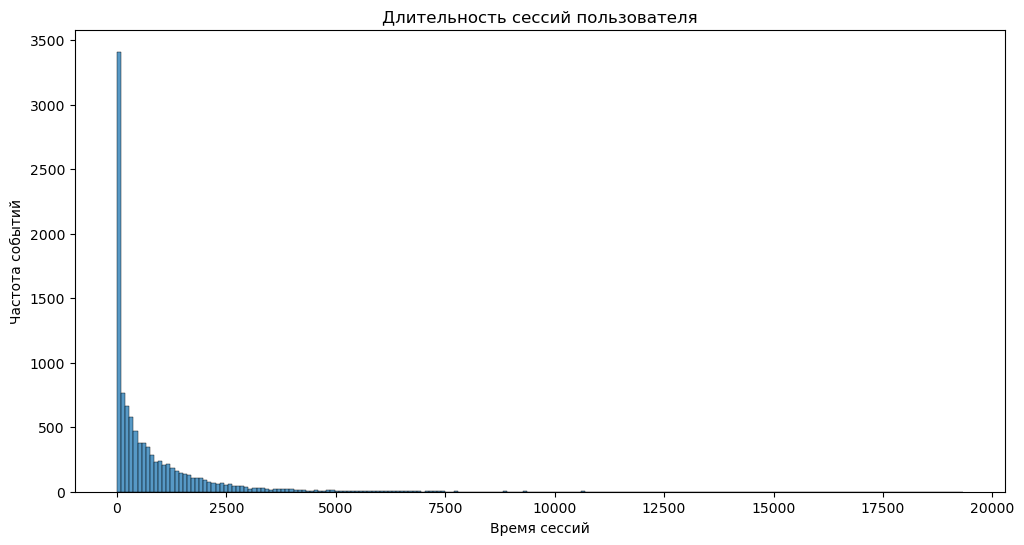

In [26]:
data_sessions =  (
    data
    .groupby('session_id')
    .agg({'time_spent': 'sum'})
    .reset_index()
)

plt.figure(figsize=(12, 6))
ax = sns.histplot(data=data_sessions, x='time_spent')
ax.set_title('Длительность сессий пользователя')
ax.set_xlabel('Время сессий') 
ax.set_ylabel('Частота событий')
plt.show()

Присутствуют нулевые и аномально долгие сессии.

In [27]:
data_sessions['time_spent'].describe()

count    10368.000000
mean       772.668981
std       1191.607952
min          0.000000
25%         21.000000
50%        335.000000
75%       1045.250000
max      19318.000000
Name: time_spent, dtype: float64

Средняя продолжительность сессии 773 секунд, медианная - 335 секунд.

Рассмотрим, как ведут себя пользователи на примере нескольких долгих сессии.

In [28]:
pd.set_option('display.max_rows', 2500)

long_session = data_sessions.query('time_spent > 10000')['session_id']
data.query('session_id in @long_session')

user_id   first_ts          event_time  \
1079   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 15:36:03   
1080   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 15:38:00   
1081   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 15:44:57   
1082   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 15:47:35   
1083   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 15:54:42   
1084   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:00:01   
1085   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:02:25   
1086   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:05:09   
1087   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:10:21   
1088   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:12:38   
1089   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:19:57   
1090   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:21:11   
1091   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:27:27   
1092   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:29:06   
1093   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:29:34   
1094   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:34:16   
1095   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:35:03   
1096   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:48:34   
1097   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:50:09   
1098   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:53:44   
1099   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 16:57:44   
1100   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:07:17   
1101   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:07:56   
1102   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:08:20   
1103   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:36:28   
1104   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:37:02   
1105   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:40:24   
1106   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:40:54   
1107   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:41:27   
1108   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:42:26   
1109   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:48:10   
1110   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:49:44   
1111   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:55:34   
1112   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 17:56:39   
1113   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:00:16   
1114   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:08:50   
1115   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:11:15   
1116   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:13:42   
1117   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:15:40   
1118   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:19:49   
1119   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:21:17   
1120   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:25:03   
1121   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:27:05   
1122   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:33:31   
1123   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:35:35   
1124   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:39:17   
1125   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:42:26   
1126   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:42:49   
1127   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 18:51:43   
1128   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 2019-10-26 19:00:55   
1129   04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791 2019-10-24 201

В аномально долгих сессиях встречаются повторяющиеся действия пользователя. Возможно это какой то баг, и пользователь не может перейти далее по юзер флоу.

In [29]:
nul_session = data_sessions.query('time_spent == 0')['session_id']
data.query('session_id in @nul_session')

user_id   first_ts          event_time  \
105    00157779-810c-4498-9e05-a1e9e3cedf93 2019-10-17 2019-11-03 17:12:10   
155    00551e79-152e-4441-9cf7-565d7eb04090 2019-10-24 2019-10-29 02:17:12   
188    00753c79-ea81-4456-acd0-a47a23ca2fb9 2019-10-17 2019-10-20 14:57:06   
237    00a93a72-3bbc-4ee7-8a81-7134f45ae009 2019-10-10 2019-10-18 15:51:02   
314    013bbb57-ca6f-4af3-b586-4a046d3d3dee 2019-10-10 2019-10-11 12:20:49   
365    0164902d-7393-47e1-9d5b-0ec4c0171cdc 2019-10-24 2019-10-26 18:50:34   
464    01d283e1-cb1c-407a-a4e0-9f72f3deecca 2019-10-17 2019-10-18 14:33:06   
465    01d283e1-cb1c-407a-a4e0-9f72f3deecca 2019-10-17 2019-10-18 14:33:06   
466    01d283e1-cb1c-407a-a4e0-9f72f3deecca 2019-10-17 2019-10-19 05:27:22   
467    01d283e1-cb1c-407a-a4e0-9f72f3deecca 2019-10-17 2019-10-20 03:52:18   
468    01d283e1-cb1c-407a-a4e0-9f72f3deecca 2019-10-17 2019-10-20 03:52:18   
469    01d283e1-cb1c-407a-a4e0-9f72f3deecca 2019-10-17 2019-10-20 07:54:02   
470    01d283e1-cb1c-407a-a4e0-9f72f3deecca 2019-10-17 2019-10-20 07:54:02   
496    02012123-f8ee-40f4-8ccd-c5859f3fbc41 2019-10-10 2019-10-29 09:13:21   
554    0216e1bd-0984-4ba4-a2b2-c186bf56b6f9 2019-10-24 2019-10-27 17:44:37   
568    024828cf-c873-43e6-8c7e-96aeb348699e 2019-10-03 2019-10-18 17:03:27   
572    024828cf-c873-43e6-8c7e-96aeb348699e 2019-10-03 2019-11-01 17:28:21   
587    02c90994-8de8-49e8-a384-415fb1602ac5 2019-10-10 2019-10-14 23:07:14   
625    02c90994-8de8-49e8-a384-415fb1602ac5 2019-10-10 2019-10-15 22:53:41   
626    02c90994-8de8-49e8-a384-415fb1602ac5 2019-10-10 2019-10-17 23:27:20   
664    030fbe1b-7e5b-49a4-af82-570189847f10 2019-10-03 2019-10-09 11:44:11   
751    03bef3ef-cce8-46ed-8c70-414b6b0486fb 2019-10-17 2019-10-20 02:29:35   
752    03bef3ef-cce8-46ed-8c70-414b6b0486fb 2019-10-17 2019-10-20 21:15:51   
757    03bef3ef-cce8-46ed-8c70-414b6b0486fb 2019-10-17 2019-10-22 15:32:11   
758    03bef3ef-cce8-46ed-8c70-414b6b0486fb 2019-10-17 2019-10-25 09:38:02   
818    041230c6-8b63-4a3f-86f5-3d9863d5386a 2019-10-17 2019-10-22 16:08:08   
857    042ebe74-a35b-41d5-abf8-ef6786918951 2019-10-17 2019-10-20 13:33:14   
915    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-08 12:21:24   
916    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-08 13:06:12   
925    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-10 11:47:25   
928    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-11 10:05:17   
929    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-28 10:09:12   
930    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-28 11:13:54   
931    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-29 11:11:25   
932    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-30 10:47:56   
933    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-10-30 14:43:38   
934    04a1f108-5d99-4c71-a575-1f3290a507b9 2019-10-03 2019-11-01 10:49:17   
1016   04adf25e-cb60-4cbd-bedc-ddc1057cde06 2019-10-10 2019-10-18 19:12:12   
1298   04e06319-c049-465c-9170-362a191a1287 2019-10-17 2019-10-18 21:07:40   
1299   04e06319-c049-465c-9170-362a191a1287 2019-10-17 2019-10-18 21:07:40   
1331   04e06319-c049-465c-9170-362a191a1287 2019-10-17 2019-10-28 19:56:03   
1510   056dec65-545a-4123-b95d-3ca96ed31133 2019-10-10 2019-10-14 18:54:05   
1768   06216934-8394-482e-a9fd-001f93bbebde 2019-10-17 2019-10-31 16:49:10   
1794   06216934-8394-482e-a9fd-001f93bbebde 2019-10-17 2019-11-02 10:09:34   
1817   06322fa8-a60f-486f-862c-df21ce5bbb83 2019-10-10 2019-10-31 19:21:43   
1826   063c0b06-6d9d-4580-8d03-f1c8f19ebfa1 2019-10-03 2019-10-12 23:25:37   
2045   06bdb96e-2712-47b3-a0af-d19f297abd6c 2019-10-10 2019-10-21 12:55:53   
2046   06bdb96e-2712-47b3-a0af-d19f297abd6c 2019-10-10 2019-10-21 22:28:59   
2047   06bdb96e-2712-47b3-a0af-d19f297abd6c 2019-10-10 2019-10-23 06:28:56   
2048   06bdb96e-2712-47b3-a0af-d19f297abd6c 2019-10-10 2019-10-23 18:32:22   
2049   06bdb96e-2712-47b3-a0af-d19f297abd6c 2019-10-10 201

В нулевых сессиях встречаются записи с одним пользователем и одним действием. Вероятно пользователь открыл приложение и сразу закрыл его. Также есть множественные действия от одного и того же пользователя, но интервал сежду ними превышает заданный нами для выделения сессий. То есть пользователь мог сделать действие, свернуть приложение и следующее действие сделать уже через несколько часов.

#### Оценим частоту событий.

In [30]:
data_events = (
    data
    .groupby('date')
    .agg(count=('event_name', 'count'))
    .reset_index()
)
data_events.head(10)

date  count
0  2019-10-07   2545
1  2019-10-08   2499
2  2019-10-09   2027
3  2019-10-10   2243
4  2019-10-11   2030
5  2019-10-12   1843
6  2019-10-13   2635
7  2019-10-14   3034
8  2019-10-15   2722
9  2019-10-16   2730

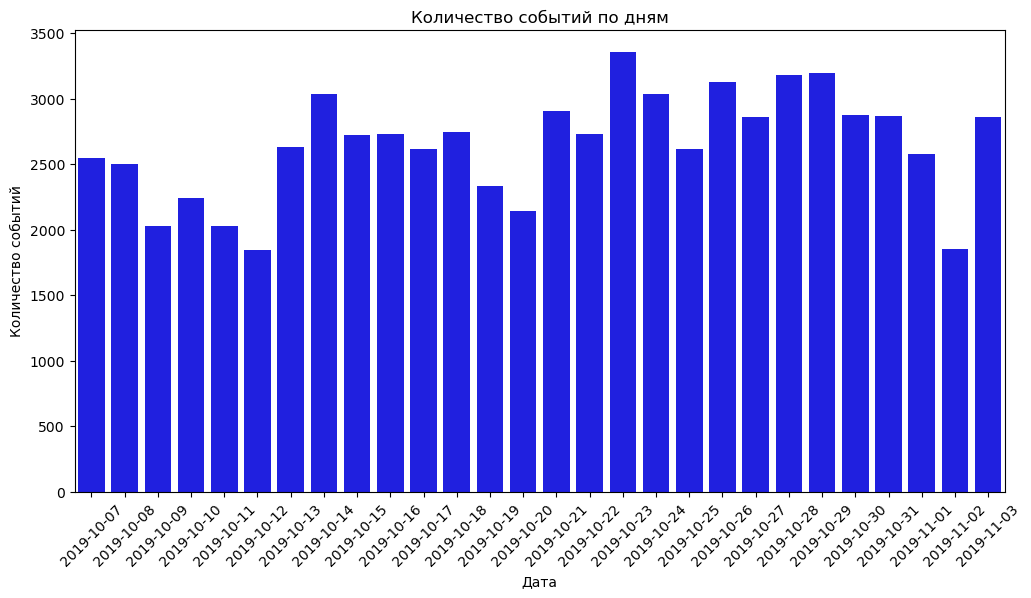

In [31]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='date', y='count', 
                 data=data_events,
                 color='blue')
ax.set_title('Количество событий по дням')
ax.set_xlabel('Дата') 
ax.set_ylabel('Количество событий')
plt.xticks(rotation=45)
plt.show()

От 1843 до 3361 событий за день. Можно заметить, что в выходные количество событий снижается.

In [32]:
data_events_by_type = (
    data
    .groupby(['date', 'event_name'])
    .agg(count=('event_name', 'count'))
    .reset_index()
) 

fig = px.bar(data_events_by_type, x='date',
             y='count', color='event_name', text='count', barmode = 'stack')
fig.update_layout(title='Распределение событий по дням',
                 xaxis_title='Дата',
                 yaxis_title='Количество событий'
                 )
fig.show()

По графику видно, что пользователи редко кликают на рекомендованные объявления и предпочитают использовать поиск. Также пользователи редко добавляют объявления в избранное.

**Оценим количество пользователей по дням.**

In [33]:
data_users = (
    data
    .groupby('date')
    .agg(count=('user_id', 'nunique'))
    .reset_index()
)
data_users.head(10)

date  count
0  2019-10-07    204
1  2019-10-08    204
2  2019-10-09    227
3  2019-10-10    233
4  2019-10-11    206
5  2019-10-12    178
6  2019-10-13    226
7  2019-10-14    298
8  2019-10-15    303
9  2019-10-16    278

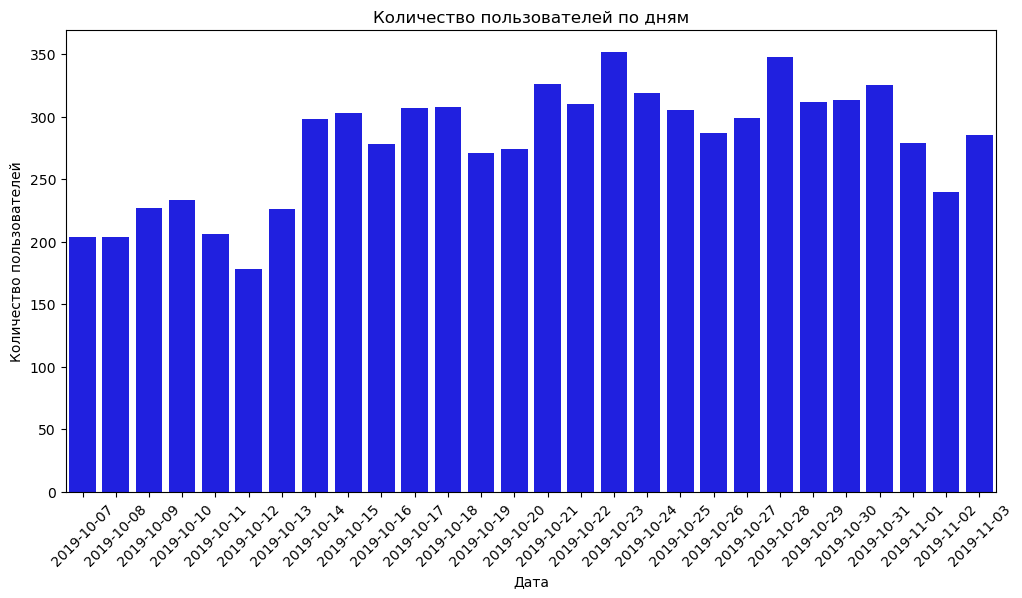

In [34]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='date', y='count', 
                 data=data_users,
                 color='blue')
ax.set_title('Количество пользователей по дням')
ax.set_xlabel('Дата') 
ax.set_ylabel('Количество пользователей')
plt.xticks(rotation=45)
plt.show()

От 178 до 352 уникальных пользователей в день. Количество пользователей начинает расти со второй недели. Также заметно снижение пользователей в выходные дни.

**Оценим количество событий на пользователя.**

In [35]:
data_user_events = (
    data
    .groupby('user_id')
    .agg(count=('event_name', 'count'))
    .reset_index()
    .sort_values('count',ascending=False)
)
data_user_events.head()

user_id  count
3397  cb36854f-570a-41f4-baa8-36680b396370    478
3794  e13f9f32-7ae3-4204-8d60-898db040bcfc    465
2629  9ce63488-758a-481a-bcb5-a02b467e1d84    407
615   21230dd9-2f7f-4b77-a436-43d4d10388e0    400
3162  be1449f6-ca45-4f94-93a7-ea4b079b8f0f    397

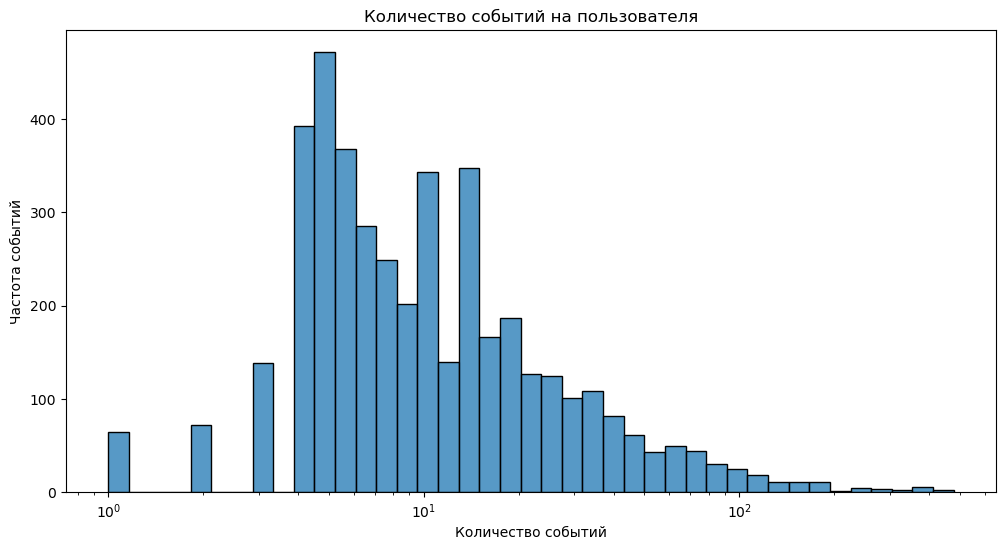

In [36]:
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=data_user_events, x='count', log_scale=True)
ax.set_title('Количество событий на пользователя')
ax.set_xlabel('Количество событий') 
ax.set_ylabel('Частота событий')
plt.show()

In [37]:
data_user_events['count'].describe()

count    4293.000000
mean       17.283252
std        29.130677
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       478.000000
Name: count, dtype: float64

От 1го до 478 событий на пользователя. 17.3 - среднее количество событий на пользователя, 9 - медианное.

Таким образом, можно сделать следующие выводы:
- Количество событий в день постепенно растет. В выходные количество событий снижается;
- Пользователи редко кликают на рекомендованные объявления и предпочитают использовать поиск. Также пользователи редко добавляют объявления в избранное;
- Количество пользователей начинает расти со второй недели. Также заметно снижение пользователей в выходные дни;
- От 1го до 478 событий на пользователя. 17.3 - среднее количество событий на пользователя, 9 - медианное.

#### Оценка конверсии в целевое событие (contacts_show).

In [38]:
total = data['user_id'].nunique()
contact_count = data.query('event_name == "contacts_show"')['user_id'].nunique()
conv = contact_count / total
print("Конверсия в целевое событие: {0:.2%}".format(conv))

Конверсия в целевое событие: 22.85%


Таким образом, можно сделать следующие выводы по общему поведению пользователей:
- После первой недели остается около четверти пользователей, а к концу наблюдения - меньше 10%. В целом удержание поользователей достаточно низкое, это должно настораживать. Необходим более подробный анализ на более полных данных, т.к. в имеющихся данных только у одной когорты лайфтайм четыре недели;
- Пользовательские сессии составляют от 0 до 19318 секунд. Средняя продолжительность сессии 773 секунд, медианная - 335 секунд;
- От 1843 до 3361 событий за день. Количество событий в день постепенно растет. В выходные количество событий снижается. Пользователи редко кликают на рекомендованные объявления и предпочитают использовать поиск. Также пользователи редко добавляют объявления в избранное. Количество пользователей начинает расти со второй недели. Также заметно снижение пользователей в выходные дни. От 1го до 478 событий на пользователя. 17.3 - среднее количество событий на пользователя, 9 - медианное;  
- Конверсии в целевое событие (contacts_show) составила 22.85%.

### Сегментируем пользователей.

Посмотрим распределение пользователей по источникам.

In [39]:
data_by_source = (
    data
    .groupby('source')
    .agg(count=('user_id', 'nunique'))
    .sort_values(by='count', ascending=False)
    .reset_index()
)    
data_by_source

source  count
0  yandex   1934
1   other   1230
2  google   1129

Разделим пользователей на группы по их источнику привлечения и посмотрим метрики в этих группах.    
Если метрики по каналам будут отличаться, то можно будет принять решение о продвижении приложения с целью привлечения новых пользователей.   
Предположим, что пользователи, пришедшие из Yandex, имеют более высокие удержание и конверсию.

In [40]:
yandex_users = data.query('source == "yandex"')['user_id'].unique().tolist()
google_users = data.query('source == "google"')['user_id'].unique().tolist()
other_users = data.query('source == "other"')['user_id'].unique().tolist()

#### Удержание пользователей по группам.

In [41]:
cohorts_ya = (
    data.query('user_id in @yandex_users')
    .groupby(['first_ts','lifetime'])
    .agg({'user_id':'nunique'})
    .reset_index()
)

cohort_size_ya = (
    cohorts_ya[cohorts_ya['lifetime'] == 0][['first_ts','user_id']]
    .rename(columns={'user_id':'cohort_users'})
)    

cohorts_ya = cohorts_ya.merge(cohort_size_ya, on='first_ts')
cohorts_ya['retention'] = cohorts_ya['user_id'] / cohorts_ya['cohort_users']
retention_ya = cohorts_ya.pivot_table(index='first_ts',columns='lifetime',values='retention',aggfunc='sum')

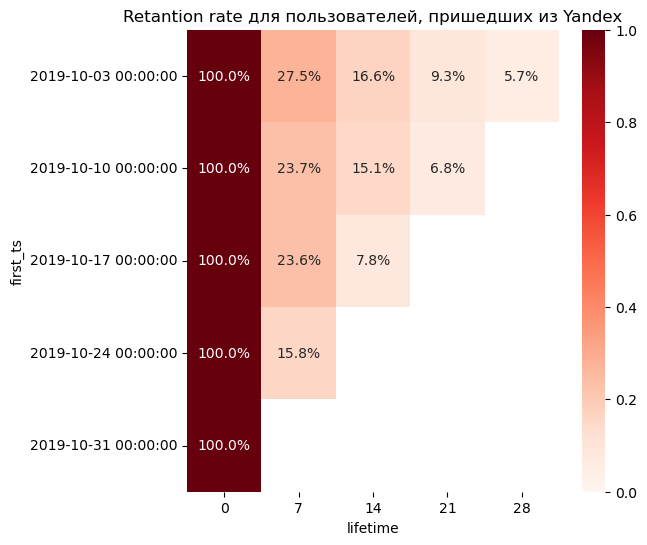

In [42]:
plt.figure(figsize=(6,6))
plt.title('Retantion rate для пользователей, пришедших из Yandex')
ax = sns.heatmap(data=retention_ya, annot=True, fmt='.1%', vmin=0.0,cmap='Reds')
ax.set_yticklabels(retention_ya.index)
fig=ax.get_figure()
plt.show()

In [43]:
cohorts_g = (
    data.query('user_id in @google_users')
    .groupby(['first_ts','lifetime'])
    .agg({'user_id':'nunique'})
    .reset_index()
)

cohort_size_g = (
    cohorts_g[cohorts_g['lifetime'] == 0][['first_ts','user_id']]
    .rename(columns={'user_id':'cohort_users'})
)    

cohorts_g = cohorts_g.merge(cohort_size_g, on='first_ts')
cohorts_g['retention'] = cohorts_g['user_id'] / cohorts_g['cohort_users']
retention_g = cohorts_g.pivot_table(index='first_ts',columns='lifetime',values='retention',aggfunc='sum')

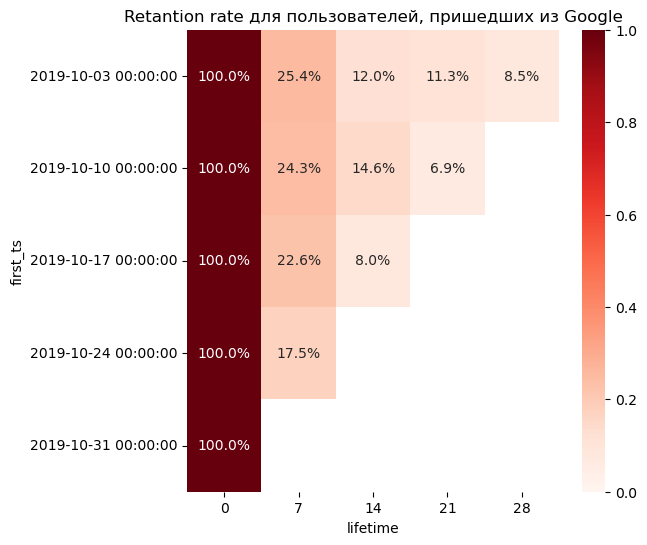

In [44]:
plt.figure(figsize=(6,6))
plt.title('Retantion rate для пользователей, пришедших из Google')
ax = sns.heatmap(data=retention_g, annot=True, fmt='.1%', vmin=0.0,cmap='Reds')
ax.set_yticklabels(retention_g.index)
fig=ax.get_figure()
plt.show()

In [45]:
cohorts_o = (
    data.query('user_id in @other_users')
    .groupby(['first_ts','lifetime'])
    .agg({'user_id':'nunique'})
    .reset_index()
)

cohort_size_o = (
    cohorts_o[cohorts_o['lifetime'] == 0][['first_ts','user_id']]
    .rename(columns={'user_id':'cohort_users'})
)    

cohorts_o = cohorts_o.merge(cohort_size_o, on='first_ts')
cohorts_o['retention'] = cohorts_o['user_id'] / cohorts_o['cohort_users']
retention_o = cohorts_o.pivot_table(index='first_ts',columns='lifetime',values='retention',aggfunc='sum')

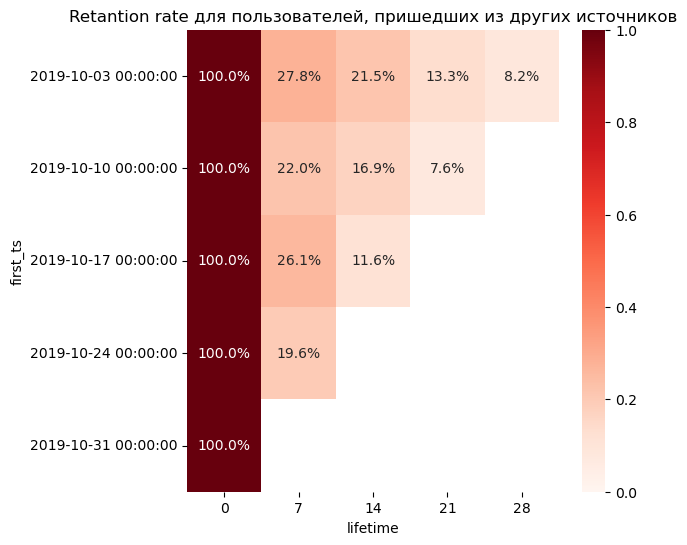

In [46]:
plt.figure(figsize=(6,6))
plt.title('Retantion rate для пользователей, пришедших из других источников')
ax = sns.heatmap(data=retention_o, annot=True, fmt='.1%', vmin=0.0,cmap='Reds')
ax.set_yticklabels(retention_o.index)
fig=ax.get_figure()
plt.show()

Можно увидеть, что удержание выше у пользователей, пришедших из Google.

####  Оценим время, проведенное в приложении, по группам.

In [47]:
data_sessions_by_source =  (
    data
    .groupby(['date', 'source'])
    .agg(mean_time=('time_spent', 'mean'))
    .reset_index()
)
data_sessions_by_source['mean_time'] = data_sessions_by_source['mean_time'].round()
data_sessions_by_source.head()

date  source  mean_time
0  2019-10-07  google      111.0
1  2019-10-07   other       90.0
2  2019-10-07  yandex      113.0
3  2019-10-08  google      107.0
4  2019-10-08   other      120.0

In [48]:
fig = px.bar(data_sessions_by_source, x='date',
             y='mean_time', color='source', text='mean_time', barmode = 'stack')
fig.update_layout(title='Распределение среднего времени в приложении по источникам по дням',
                 xaxis_title='Дата',
                 yaxis_title='Время'
                 )
fig.show()

По среднему времени, проведенному в приложении, лидируют пользователи, пришедшие из Yandex.

#### Оценим частоту действий пользователей по группам.

In [49]:
data_events_by_source =  (
    data
    .groupby(['date', 'source'])
    .agg(count=('event_name', 'count'))
    .reset_index()
)

fig = px.bar(data_events_by_source, x='date',
             y='count', color='source', text='count', barmode = 'stack')
fig.update_layout(title='Распределение событий по дням по источникам',
                 xaxis_title='Дата',
                 yaxis_title='Количество событий'
                 )
fig.show()

По ежедневному количеству событий также лидируют пользователи, пришедшие из Yandex.

#### Конверсия пользователей по группам.

In [50]:
total_ya = len(yandex_users)
contact_count_ya = data.query('(event_name == "contacts_show") and (user_id in @yandex_users)')['user_id'].nunique()
conv_ya = contact_count_ya / total_ya

total_g = len(google_users)
contact_count_g = data.query('(event_name == "contacts_show") and (user_id in @google_users)')['user_id'].nunique()
conv_g = contact_count_g / total_g

total_o = len(other_users)
contact_count_o = data.query('(event_name == "contacts_show") and (user_id in @other_users)')['user_id'].nunique()
conv_o = contact_count_o / total_o

print("Конверсия в целевое событие пользователей, пришедших из Yandex: {0:.2%}".format(conv_ya))
print("Конверсия в целевое событие пользователей, пришедших из Google: {0:.2%}".format(conv_g))
print("Конверсия в целевое событие пользователей, пришедших из других источников: {0:.2%}".format(conv_o))

Конверсия в целевое событие пользователей, пришедших из Yandex: 24.72%
Конверсия в целевое событие пользователей, пришедших из Google: 24.36%
Конверсия в целевое событие пользователей, пришедших из других источников: 18.54%


Как мы видим, пользователи, пришедшие из Yandex, показывают самую высокую конверсию.

Таким образом, после разделения пользователей на группы по их источнику привлечения можно сделать следующие выводы:
1. Удержание выше у пользователей, пришедших из Google, что отличается от нашего предположения.
2. По среднему времени, проведенному в приложении, лидируют пользователи, пришедшие из Yandex.
3. По ежедневному количеству событий также лидируют пользователи, пришедшие из Yandex.
4. Пользователи, пришедшие из Yandex, показывают самую высокую конверсию 24.72%, что соответствует нашему предположению, но конверсия пользователей из Google примерно на том же уровне (24.36%).

### Статистические гипотезы.

#### Группы пользователей, установивших приложение из `yandex` и `google`, демонстрируют разную конверсию в просмотры контактов.

Сформулируем гипотезы:   
**Нулевая**: конверсия пользователей, установивших приложение из `yandex` и `google`, одинаковая.   
**Альтернативная**: конверсия пользователей, установивших приложение из `yandex` и `google`, отличаются.

Чтобы проверить гипотезу применим Z-test.

In [51]:
alpha = 0.05  # критический уровень статистической значимости

# число пользователей в группе 1 и группе 2:
n_users = np.array([total_ya,
                   total_g])

# число пользователей, совершивших событие в группе 1 и группе 2
success = np.array([contact_count_ya, 
                   contact_count_g])

# пропорции успехов в группах:
p1 = success[0]/n_users[0]
p2 = success[1]/n_users[1]
    
# пропорция успехов в комбинированном датасете:
p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Группы пользователей, воспользовавшиеся поиском и кликнувших на рекомендованное объявление, демонстрируют разную конверсию в просмотры контактов.

Сформулируем гипотезы:   
**Нулевая**: конверсия пользователей, воспользовавшиеся поиском и кликнувших на рекомендованное объявление, одинаковая.   
**Альтернативная**: конверсия пользователей, воспользовавшиеся поиском и кликнувших на рекомендованное объявление, отличаются.

In [52]:
search_users = data.query('event_name == "search"')['user_id'].unique().tolist()
tips_click_users = data.query('event_name == "tips_click"')['user_id'].unique().tolist()

search_cont_sh = data.query('(user_id in @search_users) and (event_name == "contacts_show")')['user_id'].nunique()
tips_cont_sh = data.query('(user_id in @tips_click_users) and (event_name == "contacts_show")')['user_id'].nunique()

In [53]:
# число пользователей в группе 1 и группе 2:
n_users = np.array([len(search_users),
                   len(tips_click_users)])

# число пользователей, совершивших событие в группе 1 и группе 2
success = np.array([search_cont_sh, 
                   tips_cont_sh])

# пропорции успехов в группах:
p1 = success[0]/n_users[0]
p2 = success[1]/n_users[1]
    
# пропорция успехов в комбинированном датасете:
p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.0011889811026417618
Отвергаем нулевую гипотезу: между долями есть разница


Таким образом, по результату проверки статистических гипотез можно сделать выводы:
1. Конверсия групп пользователей, разделенных по типу источника (`Yandex` и `Google`), не имеет статистического различия.
2. Конверсия групп пользователей, разделенных по типу совершенных событий (`search` и `tips_click`), имеет статистическое различие.

### Выводы и рекомендации.

**Выводы:**
- Retantion Rate:     

После первой недели остается около четверти пользователей, а к концу наблюдения - меньше 10%. В целом удержание поользователей достаточно низкое, это должно настораживать. Необходим более подробный анализ на более полных данных, т.к. в имеющихся данных только у одной когорты лайфтайм четыре недели.

- Время, проведенное в приложении:   

Мы выделили пользовательские сессии на основе таймаута между событиями в 30 минут. Сессии составляют от 0 до 19318 секунд. Средняя продолжительность сессии 773 секунд, медианная - 335 секунд.

- Частота событий:   

От 1843 до 3361 событий за день. Количество событий в день постепенно растет. В выходные количество событий снижается.    
Пользователи редко кликают на рекомендованные объявления и предпочитают использовать поиск. Также пользователи редко добавляют объявления в избранное.   
Количество пользователей начинает расти со второй недели. Также заметно снижение пользователей в выходные дни.    
От 1го до 478 событий на пользователя. 17.3 - среднее количество событий на пользователя, 9 - медианное.     

- Конверсии в целевое событие (contacts_show) составила 22.85%


Далее мы выделили группы пользователей на основе их источника и оценили метрики в этих группах.   

- Удержание выше у пользователей, пришедших из Google
- По среднему времени, проведенному в приложении, лидируют пользователи, пришедшие из Yandex.
- По ежедневному количеству событий также лидируют пользователи, пришедшие из Yandex.
- Пользователи, пришедшие из Yandex, показывают самую высокую конверсию 24.72%, но конверсия пользователей из Google примерно на том же уровне (24.36%).

Далее мы выдвинули и проверили статистические гипотезы. И по результату сделали следующие выводы:
1. Конверсия групп пользователей, разделенных по типу источника (`Yandex` и `Google`), не имеет статистического различия.
2. Конверсия групп пользователей, разделенных по типу совершенных событий (`search` и `tips_click`), имеет статистическое различие.

**Рекомендации:**
- Необходим дополнительный анализ Retantion Rate на более полных данных. 
- Т.к. пользователи, кликнувшие на рекомендованное объявление, показывают хорошую конверсию, будет логичным совершенствовать алгоритм выдачи рекомендованных объявлений, чтобы они были более релевантными интересам пользователя.
- Возможно, стоит развивать дополнительные источники привлечения пользователей, помимо `Yandex` и `Google`. 